In [12]:
from model_trainer import *
from dataset import Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import normaltest, ttest_rel, wilcoxon
from tqdm import tqdm

sns.set_theme(context="paper", style="white", palette="deep")
seed = 42

TRAIN_MODELS = False

In [13]:
scaler = 'minmax'
ds = {}
ds['A'] = Dataset('spinning_data.csv', scaler=scaler)
ds['B'] = Dataset('spinning_data_embeddings.csv', scaler=scaler)
#cv_type = 'kfold'
cv_type = 'groupkfold'
n_folds = 3
n_inner_folds = 5
mt = ModelTrainer(n_outer_folds=n_folds, n_inner_folds=n_inner_folds, cv_type=cv_type, random_state=seed)
models = {}
study_params = {
    'n_trails': 50,
    'timeout': 1800,
    'n_jobs': -1
}
targets = ds['A'].target_columns
targets_ordered = 'Strength (MPa)', 'Strain (mm/mm)', 'Toughness Modulus (MJ m-3)', 'Diameter (µm)', 'Youngs Modulus (GPa)'

/home/erik/Repositories/Spinning-condition-and-mechanical-properties/src/dataset.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.0, 1.0, 1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0, 1.0, 1.0]
Length: 2190
Categories (2, float64): [1.0, 2.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self._df.loc[:, self.categorical_columns] = self._df.loc[:, self.categorical_columns].astype('category')
/home/erik/Repositories/Spinning-condition-and-mechanical-properties/src/dataset.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.0, 1.0, 1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0, 1.0, 1.0]
Length: 2190
Categories (2, float64): [1.0, 2.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self._df.loc[:, self.categorical_columns] = self._df.loc[:, self.categorical_columns].ast

In [14]:
print(f'Number of rows: {len(ds['A'])}')
print(f'Number of columns: {len(ds['A'].columns)}')
print(f'Number of columns (PCA): {len(ds['B'].columns)}')
#print(ds['A'].df.loc[:,'Protein'].value_counts(normalize=True))
#print(ds['A'].df.loc[:,'Sample number'].value_counts(normalize=False).to_string())

Number of rows: 2190
Number of columns: 24
Number of columns (PCA): 39


In [15]:
if TRAIN_MODELS:
    for k in 'A', 'B':
        models[k] = {}
        for target in targets:
            model_params = mt.hyperparameter_search(ds[k], study_name=k, **study_params, target=target)
            models[k][target] = mt.train_model(ds[k], model_params, target=target)
            for i, model in enumerate(models[k][target]):
                save_model(model, f'../models/model_{k}_fold_{i}_{target.split()[0]}')

In [16]:
for k in 'A', 'B':
    models[k] = {}
    for target in targets:
        models[k][target] = [None] * n_folds
        for i in range(n_folds):
            models[k][target][i] = load_model(f'../models/model_{k}_fold_{i}_{target.split()[0]}')
            models[k][target][i].categorical_features = ds[k].categorical_columns

/usr/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator OrdinalEncoder from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid re

/usr/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [17]:
data_stats = pd.DataFrame(index=['Mean', 'SD', 'CV'],  
                          data=[ds['A'].targets.loc[:, targets_ordered].mean(), 
                                ds['A'].targets.loc[:, targets_ordered].std(ddof=1),
                                ds['A'].targets.loc[:, targets_ordered].std(ddof=1) / ds['A'].targets.loc[:, targets_ordered].mean()])\
    .rename(columns=dict(zip(targets_ordered, ['Strength', 'Strain', 'Toughness', "Young's modulus", 'Diameter'])))\
    .map(lambda x: '{:.2E}'.format(x))
print(data_stats.to_latex())
data_stats

\begin{tabular}{llllll}
\toprule
 & Strength & Strain & Toughness & Young's modulus & Diameter \\
\midrule
Mean & 2.58E-01 & 3.96E-01 & 2.52E-01 & 1.91E-01 & 1.86E-01 \\
SD & 1.14E-01 & 2.61E-01 & 1.73E-01 & 1.09E-01 & 7.29E-02 \\
CV & 4.41E-01 & 6.60E-01 & 6.89E-01 & 5.69E-01 & 3.92E-01 \\
\bottomrule
\end{tabular}



,Strength,Strain,Toughness,Young's modulus,Diameter
Mean,2.58E-01,3.96E-01,2.52E-01,1.91E-01,1.86E-01
SD,1.14E-01,2.61E-01,1.73E-01,1.09E-01,7.29E-02
CV,4.41E-01,6.60E-01,6.89E-01,5.69E-01,3.92E-01


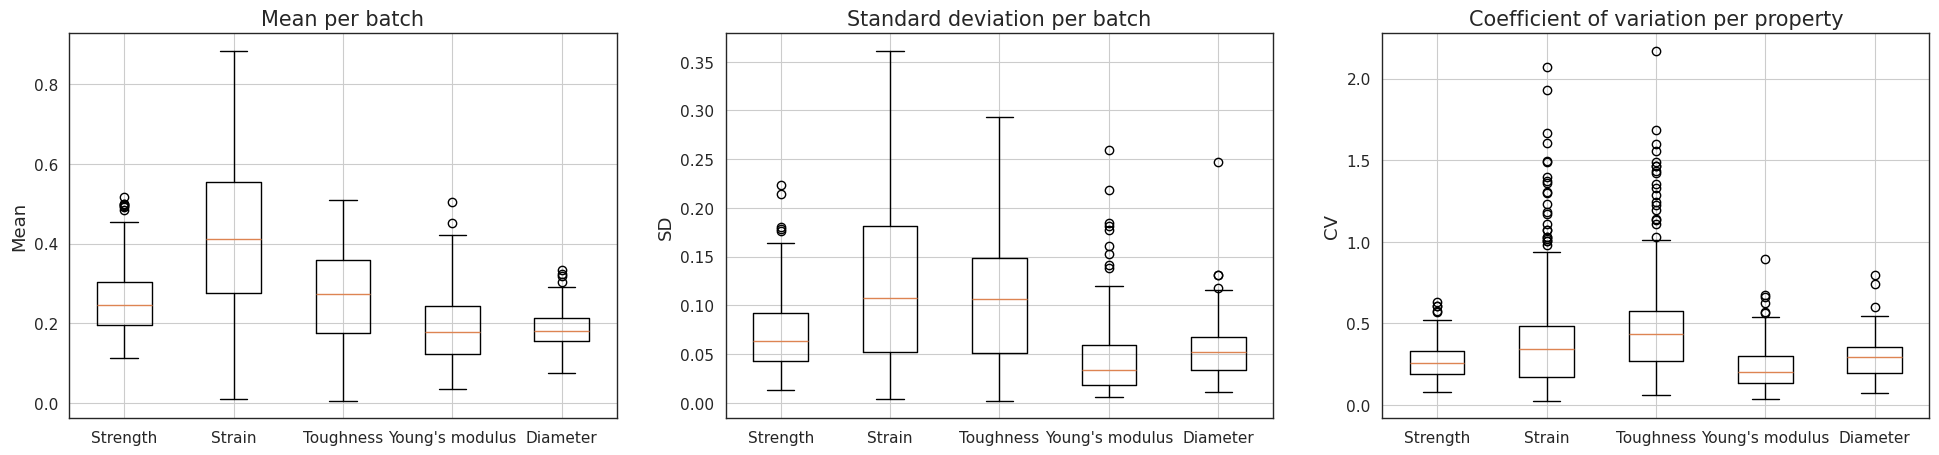

In [18]:
batch_df = {}
df = ds['A'].group_samples()
for key in 'mean', 'std', 'cv':
    batch_df[key] = pd.DataFrame()
for i in range(len(df)):
    # Ignore 1 sample batches (calculated means).
    if len(df.iloc[i, -1]) == 1: 
        continue
    for key in 'mean', 'std', 'cv':
        batch_df[key].at[i, 'Sample number'] = df.at[i, 'Sample number']
    for col in df.iloc[:, -5:].columns:
        batch_df['mean'].at[i, col] = np.mean(df.at[i, col])
        batch_df['std'].at[i, col] = np.std(df.at[i, col], ddof=1)
        batch_df['cv'].at[i, col] = batch_df['std'].at[i, col] / batch_df['mean'].at[i, col]

target_names = 'Strength', 'Strain', 'Toughness', "Young's modulus", 'Diameter', 

fig, ax = plt.subplots(1, 3)
fig.set_figwidth(24)
fig.set_figheight(5)

ax[0].boxplot(batch_df['mean'].loc[:, targets_ordered], tick_labels=target_names)
ax[0].set_title("Mean per batch", fontsize=15)
ax[0].set_ylabel("Mean", fontsize=13)
ax[0].xaxis.set_tick_params(labelsize=11)
ax[0].yaxis.set_tick_params(labelsize=11)
ax[0].grid(True)

ax[1].boxplot(batch_df['std'].loc[:, targets_ordered], tick_labels=target_names)
ax[1].set_title("Standard deviation per batch", fontsize=15)
ax[1].set_ylabel("SD", fontsize=13)
ax[1].xaxis.set_tick_params(labelsize=11)
ax[1].yaxis.set_tick_params(labelsize=11)
ax[1].grid(True)

ax[2].boxplot(batch_df['cv'].loc[:, targets_ordered], tick_labels=target_names)
ax[2].set_title("Coefficient of variation per property", fontsize=15)
ax[2].set_ylabel("CV", fontsize=13)
ax[2].xaxis.set_tick_params(labelsize=11)
ax[2].yaxis.set_tick_params(labelsize=11)
ax[2].grid(True)

plt.show()
fig.savefig('../figures/label_noise.png', bbox_inches='tight')

In [19]:
metrics_tot = {}

X = {}
X_tot = {}
Y_true = [None] * n_folds
Y_pred = {}
Y_pred_tot = {}
for k in 'A', 'B':
    X_, Y = ds[k]()
    X[k] = [None] * n_folds
    Y_pred[k] = [None] * n_folds
    for fold, (train_idx, test_idx) in enumerate(mt._outer_cv.split(X_, groups=ds[k].sample_numbers.to_numpy())):
        X[k][fold] = X_.iloc[test_idx].copy()
        Y_true[fold] = Y.iloc[test_idx].copy()
        Y_pred[k][fold] = pd.DataFrame(columns=Y_true[fold].columns)
        for target in targets:
            Y_pred[k][fold].loc[:, target] = models[k][target][fold].predict(X_.iloc[test_idx].copy())
        Y_pred[k][fold] = Y_pred[k][fold].astype(float)
    X_tot[k] = pd.DataFrame(data=np.vstack(X[k]), columns=X_.columns)
    Y_true_tot = pd.DataFrame(data=np.vstack(Y_true), columns=Y.columns)
    Y_pred_tot[k] = pd.DataFrame(data=np.vstack(Y_pred[k]), columns=Y.columns)
    metrics_tot[k] = compute_metrics(Y_true_tot, Y_pred_tot[k])

In [20]:
df_A = metrics_tot['A'].loc[:, targets_ordered]
df_B = metrics_tot['B'].loc[:, targets_ordered]
target_names = 'Strength', 'Strain', 'Toughness', 'Diameter', "Young's modulus"
table = pd.DataFrame(index=target_names,
                     columns=['$A$', '$B$', '$B-A$', '$A$', '$B$', '$B-A$', '$A$', '$B$', '$B-A$', '$A$', '$B$', '$B-A$'],
                     data=np.vstack((df_A.iloc[0, :].to_numpy(), df_B.iloc[0, :].to_numpy(), df_B.iloc[0, :].to_numpy() - df_A.iloc[0, :].to_numpy(),
                                     df_A.iloc[1, :].to_numpy(), df_B.iloc[1, :].to_numpy(), df_B.iloc[1, :].to_numpy() - df_A.iloc[1, :].to_numpy(),
                                     df_A.iloc[2, :].to_numpy(), df_B.iloc[2, :].to_numpy(), df_B.iloc[2, :].to_numpy() - df_A.iloc[2, :].to_numpy(),
                                     df_A.iloc[3, :].to_numpy(), df_B.iloc[3, :].to_numpy(), df_B.iloc[3, :].to_numpy() - df_A.iloc[3, :].to_numpy())).T).map(lambda x: '{:.2E}'.format(x))
print(table.to_latex())
table

\begin{tabular}{lllllllllllll}
\toprule
 & $A$ & $B$ & $B-A$ & $A$ & $B$ & $B-A$ & $A$ & $B$ & $B-A$ & $A$ & $B$ & $B-A$ \\
\midrule
Strength & 9.93E-02 & 9.69E-02 & -2.43E-03 & 7.24E-02 & 6.99E-02 & -2.43E-03 & 2.41E-01 & 2.78E-01 & 3.67E-02 & 5.18E-01 & 5.31E-01 & 1.35E-02 \\
Strain & 2.15E-01 & 2.15E-01 & -7.52E-04 & 1.60E-01 & 1.60E-01 & -6.42E-04 & 3.21E-01 & 3.25E-01 & 4.74E-03 & 5.78E-01 & 5.81E-01 & 3.32E-03 \\
Toughness & 1.55E-01 & 1.56E-01 & 1.08E-03 & 1.20E-01 & 1.20E-01 & 6.77E-04 & 2.00E-01 & 1.89E-01 & -1.11E-02 & 4.58E-01 & 4.39E-01 & -1.86E-02 \\
Diameter & 7.51E-02 & 7.50E-02 & -7.97E-05 & 5.02E-02 & 5.00E-02 & -1.84E-04 & 5.25E-01 & 5.26E-01 & 1.01E-03 & 7.27E-01 & 7.29E-01 & 2.12E-03 \\
Young's modulus & 7.26E-02 & 7.26E-02 & 2.06E-05 & 5.40E-02 & 5.34E-02 & -5.75E-04 & 9.66E-03 & 9.10E-03 & -5.63E-04 & 2.21E-01 & 2.27E-01 & 5.32E-03 \\
\bottomrule
\end{tabular}



,$A$,$B$,$B-A$,$A$,$B$,$B-A$,$A$,$B$,$B-A$,$A$,$B$,$B-A$
Strength,9.93E-02,9.69E-02,-2.43E-03,7.24E-02,6.99E-02,-2.43E-03,2.41E-01,2.78E-01,3.67E-02,5.18E-01,5.31E-01,1.35E-02
Strain,2.15E-01,2.15E-01,-7.52E-04,1.60E-01,1.60E-01,-6.42E-04,3.21E-01,3.25E-01,4.74E-03,5.78E-01,5.81E-01,3.32E-03
Toughness,1.55E-01,1.56E-01,1.08E-03,1.20E-01,1.20E-01,6.77E-04,2.00E-01,1.89E-01,-1.11E-02,4.58E-01,4.39E-01,-1.86E-02
Diameter,7.51E-02,7.50E-02,-7.97E-05,5.02E-02,5.00E-02,-1.84E-04,5.25E-01,5.26E-01,1.01E-03,7.27E-01,7.29E-01,2.12E-03
Young's modulus,7.26E-02,7.26E-02,2.06E-05,5.40E-02,5.34E-02,-5.75E-04,9.66E-03,9.10E-03,-5.63E-04,2.21E-01,2.27E-01,5.32E-03


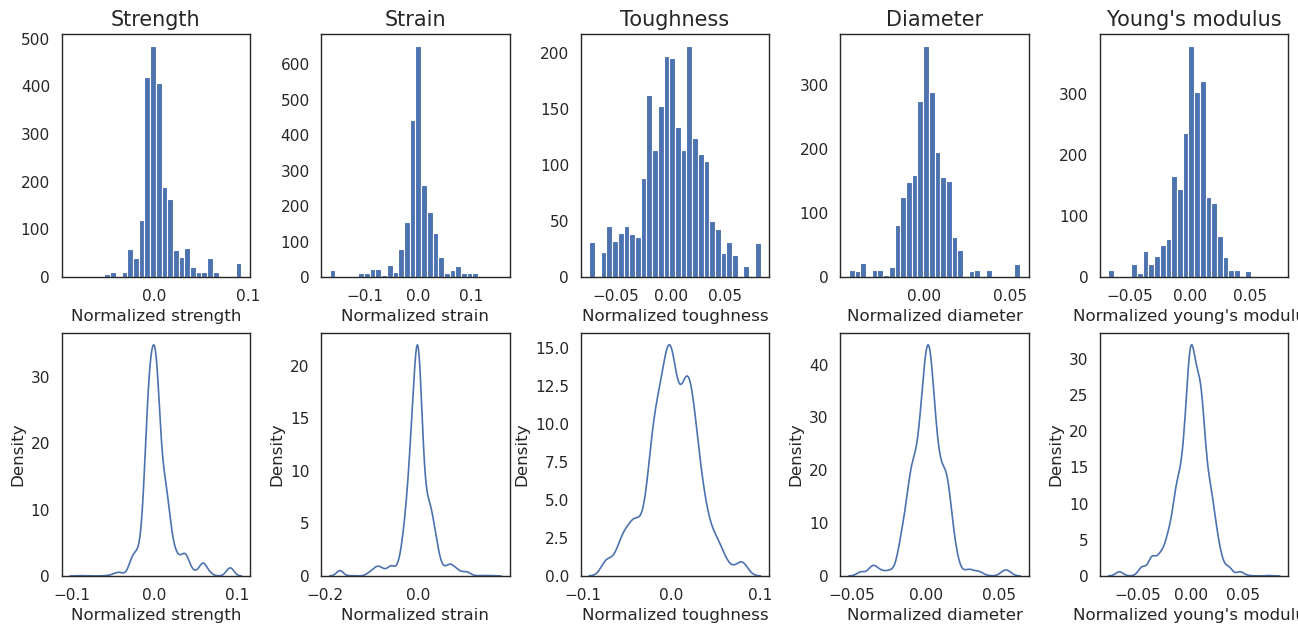

NormaltestResult(statistic=array([793.11129863, 529.67769761,   8.88294382, 199.93330506,
       250.63751168]), pvalue=array([5.99887393e-173, 9.59288790e-116, 1.17785887e-002, 3.84622275e-044,
       3.75626186e-055]))
\begin{tabular}{llllll}
\toprule
 & $A-B$ mean & $t$-statistic & $p$-value & CI-low & CI-high \\
\midrule
Strength & 4.50E-03 & 1.08E+01 & 2.00E-26 & 3.68E-03 & 5.31E-03 \\
Strain & -5.98E-04 & -8.31E-01 & 4.06E-01 & -2.01E-03 & 8.14E-04 \\
Toughness & 1.45E-03 & 2.36E+00 & 1.82E-02 & 2.47E-04 & 2.65E-03 \\
Diameter & 1.28E-03 & 4.77E+00 & 1.97E-06 & 7.51E-04 & 1.80E-03 \\
Young's modulus & 7.86E-04 & 2.31E+00 & 2.10E-02 & 1.18E-04 & 1.45E-03 \\
\bottomrule
\end{tabular}

WilcoxonResult(statistic=array([1004196., 1192343., 1106726., 1026749., 1043771.]), pvalue=array([4.06725895e-11, 8.07014965e-01, 1.70566816e-03, 5.23390785e-09,
       1.40645210e-07]))


,$A-B$ mean,$t$-statistic,$p$-value,CI-low,CI-high
Strength,4.50E-03,1.08E+01,2.00E-26,3.68E-03,5.31E-03
Strain,-5.98E-04,-8.31E-01,4.06E-01,-2.01E-03,8.14E-04
Toughness,1.45E-03,2.36E+00,1.82E-02,2.47E-04,2.65E-03
Diameter,1.28E-03,4.77E+00,1.97E-06,7.51E-04,1.80E-03
Young's modulus,7.86E-04,2.31E+00,2.10E-02,1.18E-04,1.45E-03


In [21]:
fig, ax = plt.subplots(2, 5)
fig.set_figwidth(13)
fig.set_figheight(6)
plt.tight_layout(w_pad=2, h_pad=2)
diff = Y_pred_tot['A'].loc[:, targets_ordered] - Y_pred_tot['B'].loc[:, targets_ordered]
target_names = 'Strength', 'Strain', 'Toughness', 'Diameter', "Young's modulus"
for i, target in enumerate(target_names):
    ax[0][i].set_title(target, fontsize=15)
    ax[0][i].set_xlabel(f'Normalized {target.lower()}', fontsize=12)
    ax[0][i].xaxis.set_tick_params(labelsize=11)
    ax[0][i].hist(diff.iloc[:, i], bins=30)
    ax[0][i].yaxis.set_tick_params(labelsize=11)
    ax[1][i].set_xlabel(f'Normalized {target.lower()}', fontsize=12)
    ax[1][i].xaxis.set_tick_params(labelsize=11)
    ax[1][i].set_ylabel('Density', fontsize=12)
    ax[1][i].yaxis.set_tick_params(labelsize=11)
    sns.kdeplot(ax=ax[1][i], data=diff.iloc[:, i])
fig.savefig('../figures/differences.png', bbox_inches='tight')
plt.show()
print(normaltest(diff))

result = ttest_rel(Y_pred_tot['A'].loc[:, targets_ordered], Y_pred_tot['B'].loc[:, targets_ordered])
ci=result.confidence_interval()

table=pd.DataFrame(index=['$A-B$ mean', '$t$-statistic', '$p$-value', 'CI-low', 'CI-high'],
                   columns=target_names,
                   data=[diff.mean().to_numpy(), result.statistic, result.pvalue, ci.low, ci.high]).T.map(lambda x: '{:.2E}'.format(x))

print(table.to_latex())
print(wilcoxon(Y_pred_tot['A'].loc[:, targets_ordered], Y_pred_tot['B'].loc[:, targets_ordered]))
table

In [22]:
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = d1.var(ddof=1), d2.var(ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = d1.mean(), d2.mean()
    return (u1 - u2) / s
cohend(Y_pred_tot['A'].iloc[:,:], Y_pred_tot['B'].iloc[:,:])

Diameter (µm)                 0.014679
Strain (mm/mm)               -0.003310
Strength (MPa)                0.062927
Youngs Modulus (GPa)          0.025765
Toughness Modulus (MJ m-3)    0.016040
dtype: float64

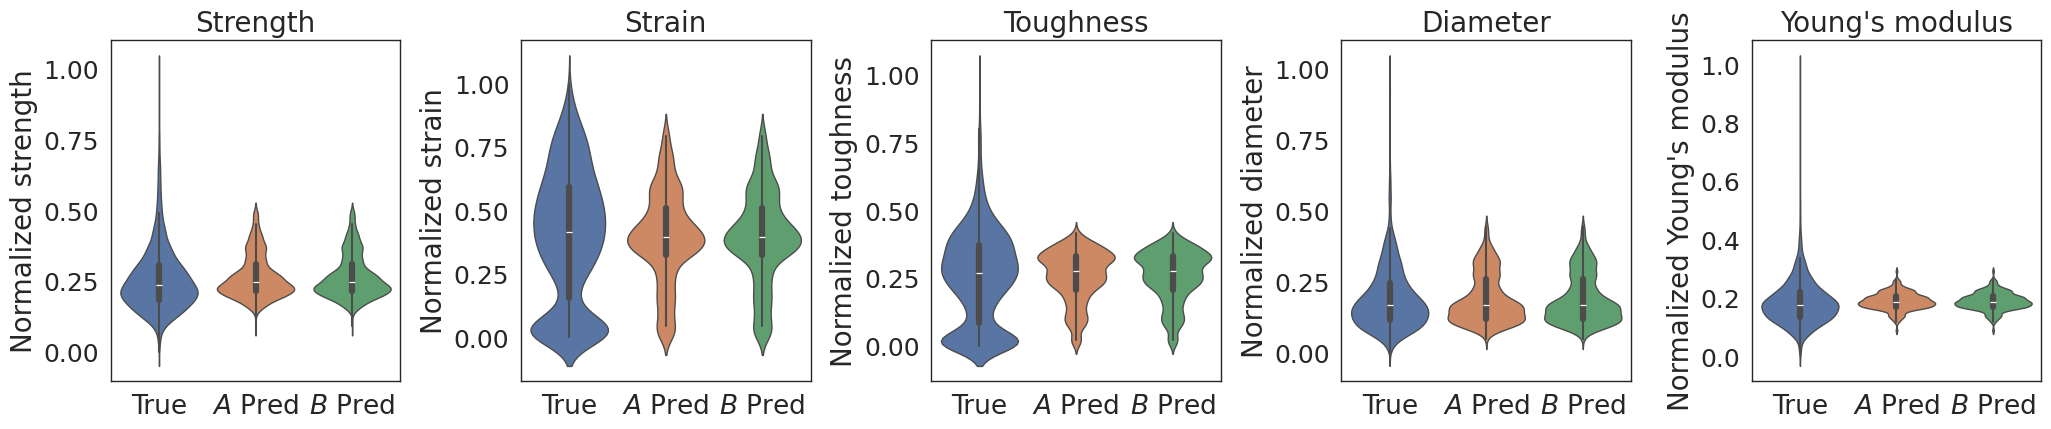

In [23]:
orientation = 'horizontal'
palettes = [None, ['g', 'm']]

fig, ax = plt.subplots(1, 5)
fig.set_figwidth(20)
fig.set_figheight(4)

plt.tight_layout(w_pad=6)
target_names = 'strength', 'strain', 'toughness', 'diameter', "Young's modulus"
for i, target in enumerate(targets_ordered):
    df = pd.DataFrame(data=np.vstack((Y_true_tot.loc[:, target].to_numpy(), 
                                      Y_pred_tot['A'].loc[:, target].to_numpy(),
                                      Y_pred_tot['A'].loc[:, target].to_numpy())).T,\
        columns=('True', '$A$ Pred', '$B$ Pred'))
    ax[i].set_ylabel(f'Normalized {target_names[i]}')
    ax[i].set_title((lambda s: s[0].upper() + s[1:])(target_names[i]), fontsize=20)
    ax[i].xaxis.set_tick_params(labelsize=19)
    ax[i].yaxis.set_tick_params(labelsize=18)
    ax[i].yaxis.label.set_fontsize(20)
    sns.violinplot(ax=ax[i], data=df, palette=palettes[0])

fig.savefig(f'../figures/distribution.png', bbox_inches='tight')
plt.show()

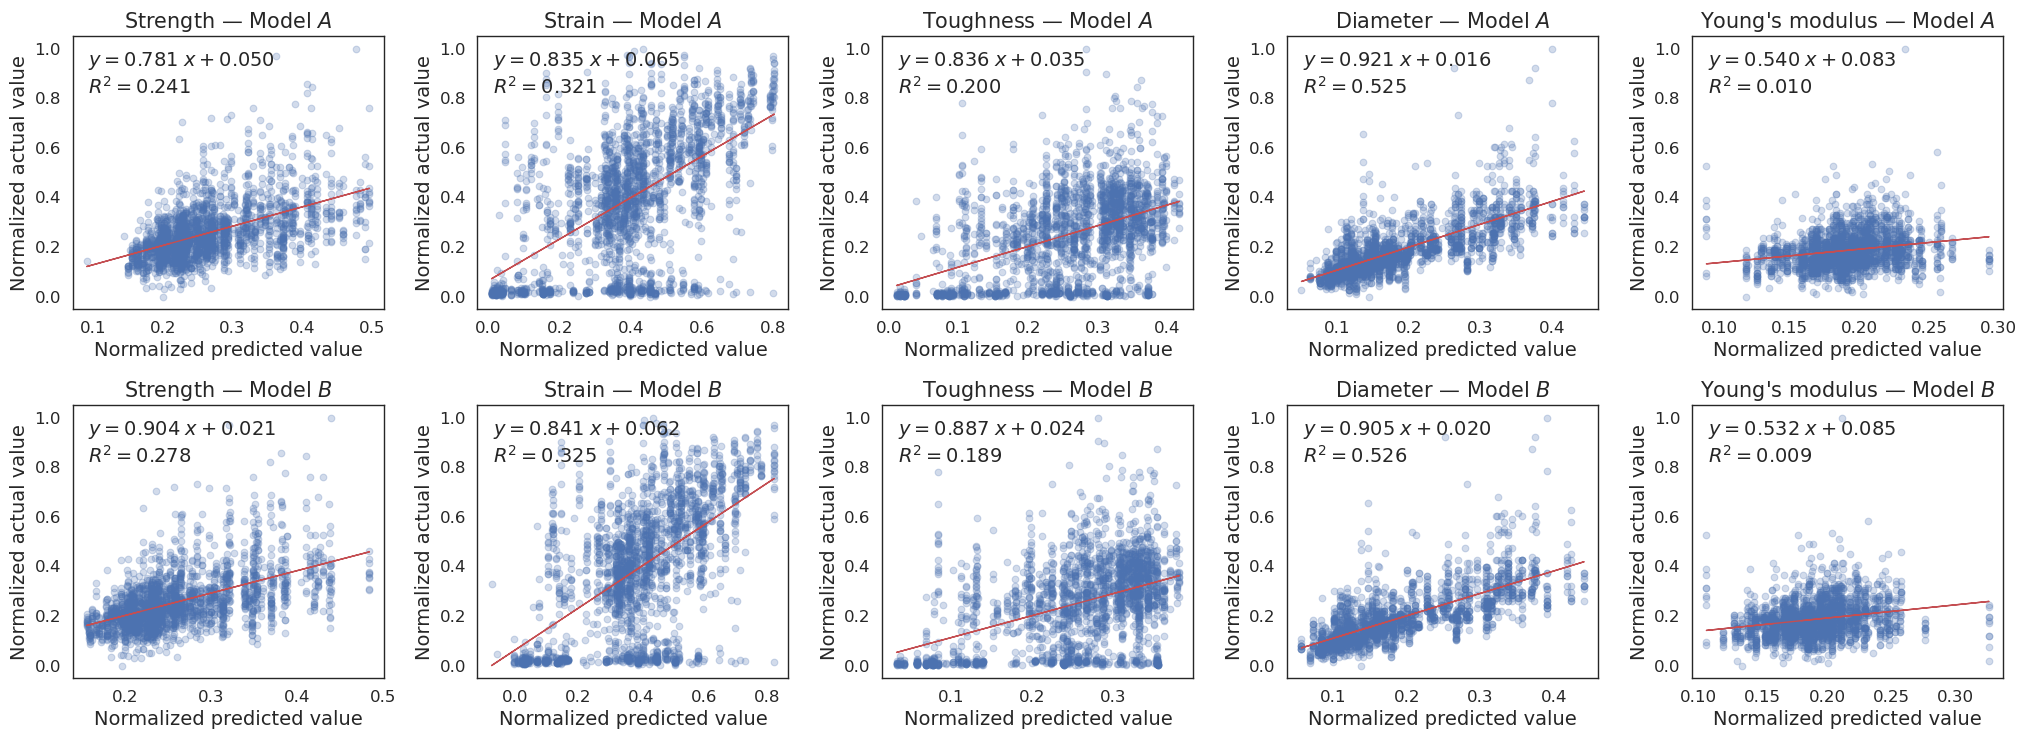

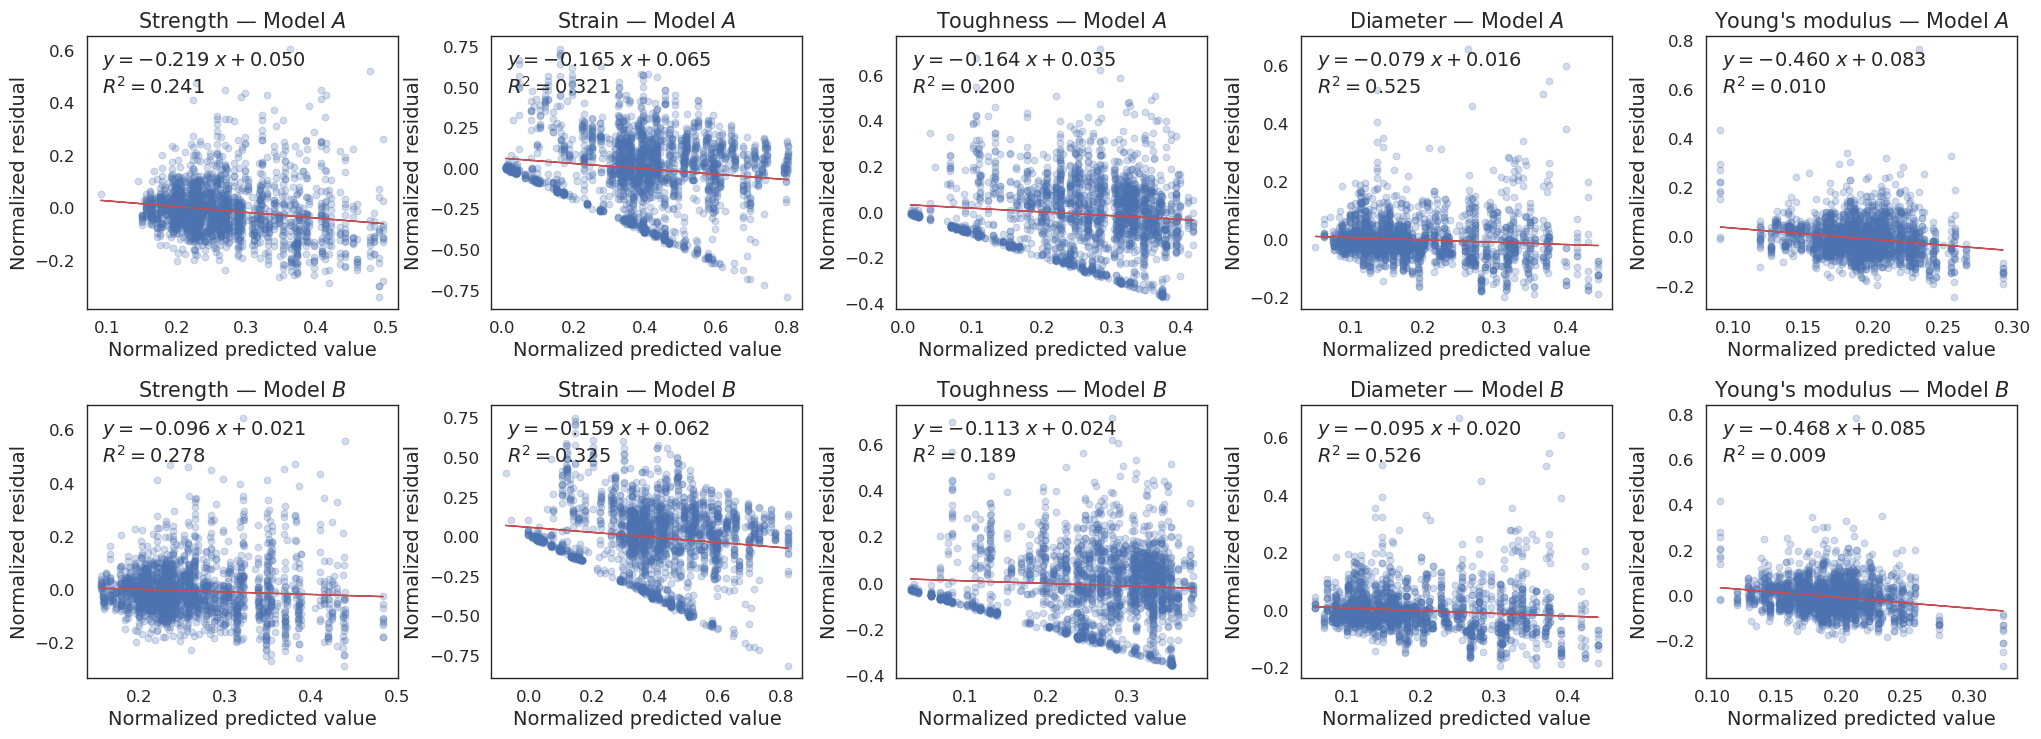

In [24]:
target_names = 'Strength', 'Strain', 'Toughness', 'Diameter', "Young's modulus"
y_label = ['Normalized actual value', 'Normalized residual']
fname = ['scatter_pred', 'scatter_residual']
for l in range(2):
    fig, axs = plt.subplots(2, 5)
    fig.set_figheight(7)
    fig.set_figwidth(20)
    fig.tight_layout(w_pad=4, h_pad=5)
    for j, k in enumerate(['A', 'B']):
        for i, target in enumerate(targets_ordered):
            x = Y_pred_tot[k].loc[:, target]
            y = Y_true_tot.loc[:, target] if l == 0 else Y_true_tot.loc[:, target] - Y_pred_tot[k].loc[:, target]
            z = np.polyfit(x, y, 1)
            y_hat = np.poly1d(z)(x)
            axs[j][i].set_title(f'{target_names[i]} — Model ${k}$', fontsize=15)
            axs[j][i].set_xlabel('Normalized predicted value', fontsize=14)
            axs[j][i].set_ylabel(y_label[l], fontsize=14)
            axs[j][i].xaxis.set_tick_params(labelsize=12)
            axs[j][i].yaxis.set_tick_params(labelsize=12)
            axs[j][i].scatter(x, y, c='b', alpha=.25)
            axs[j][i].plot(x, y_hat, "r-", lw=1)
            text = r"$y={:0.3f}\;x+{:0.3f}$".format(z[0], z[1]) + "\n" + r"$R^2 = {:0.3f}$".format(metrics_tot[k].loc['$R^2$', target])
            axs[j][i].text(0.05, 0.95, text, transform=axs[j][i].transAxes,
            fontsize=14, verticalalignment='top')
    fig.savefig(f'../figures/{fname[l]}.png', bbox_inches='tight')
    plt.show()

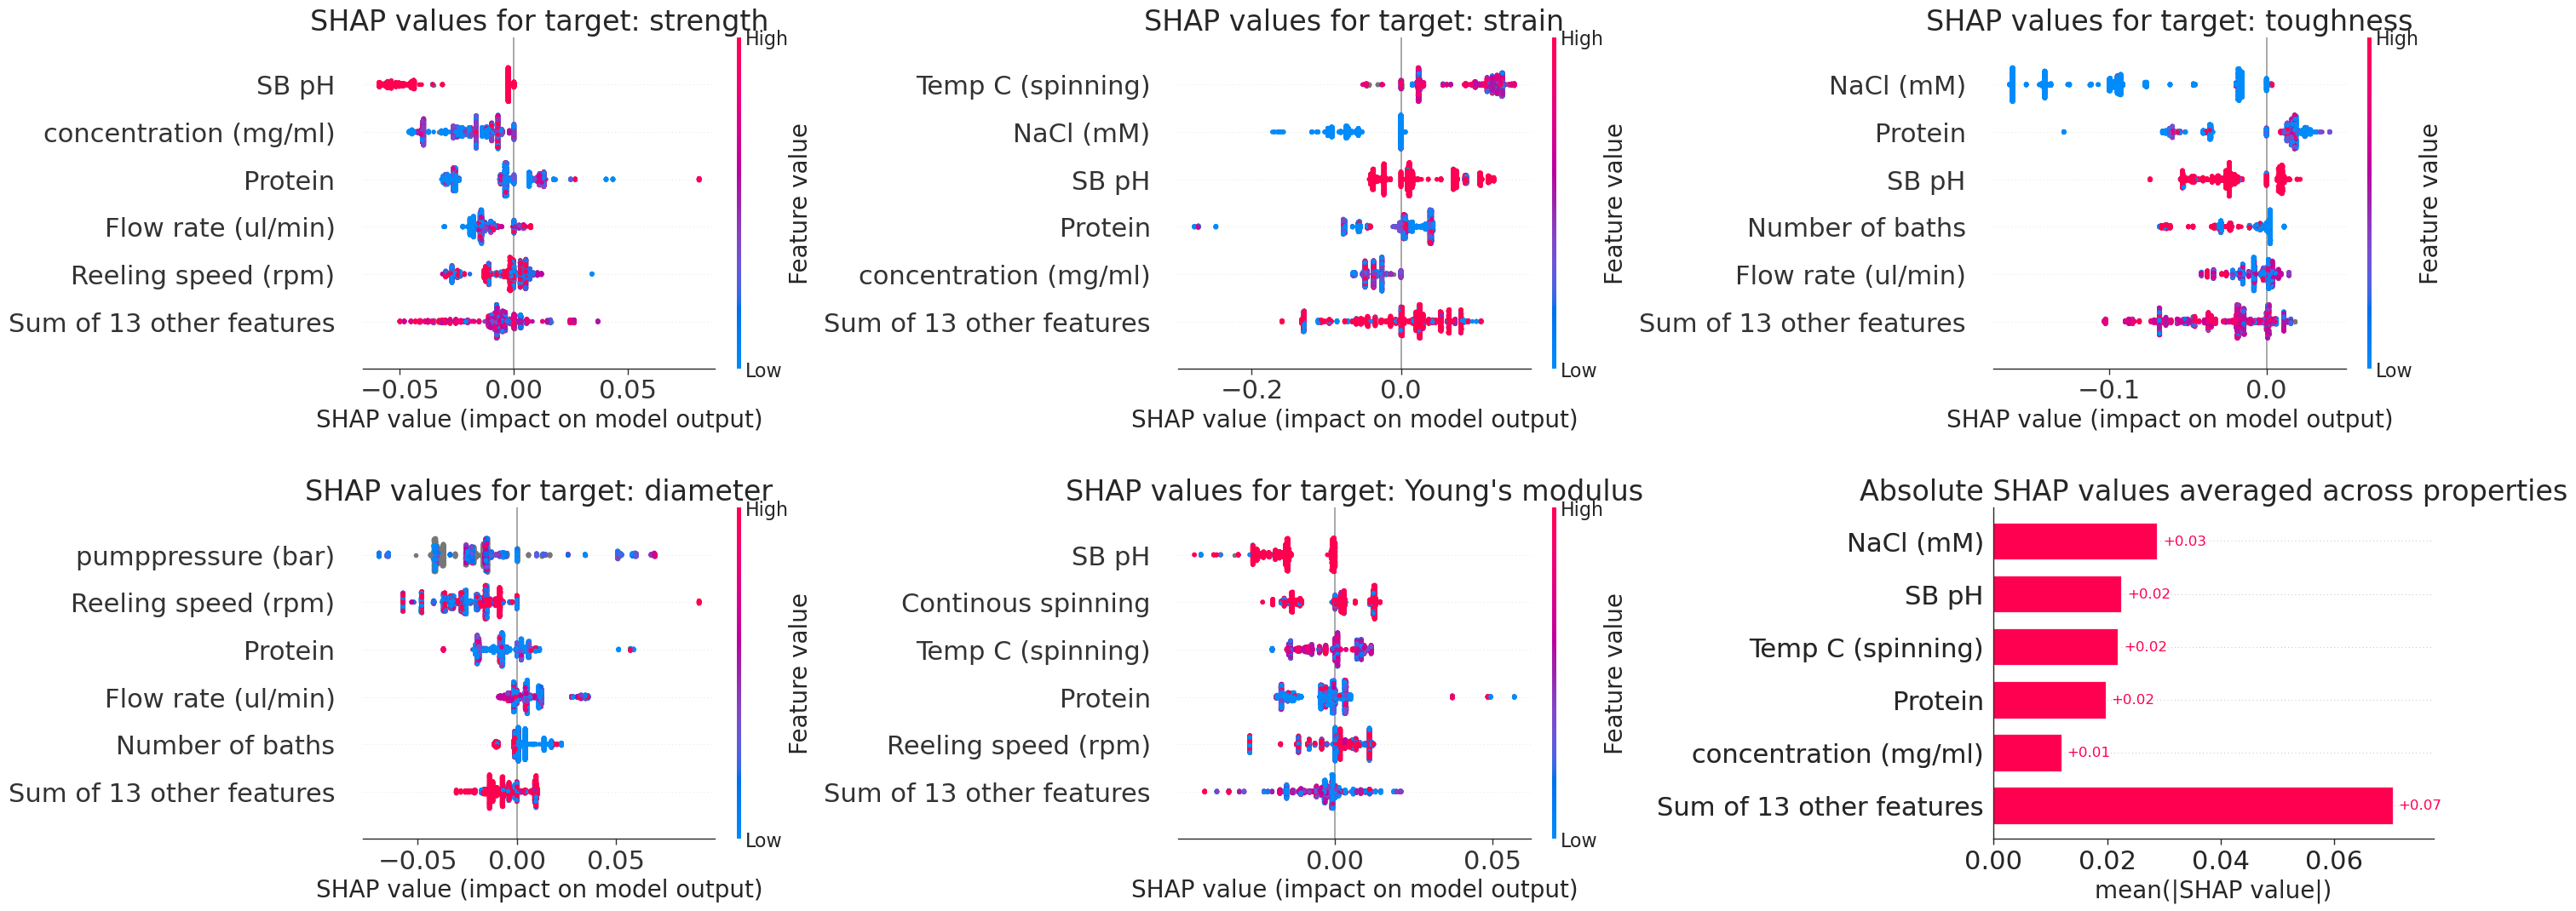

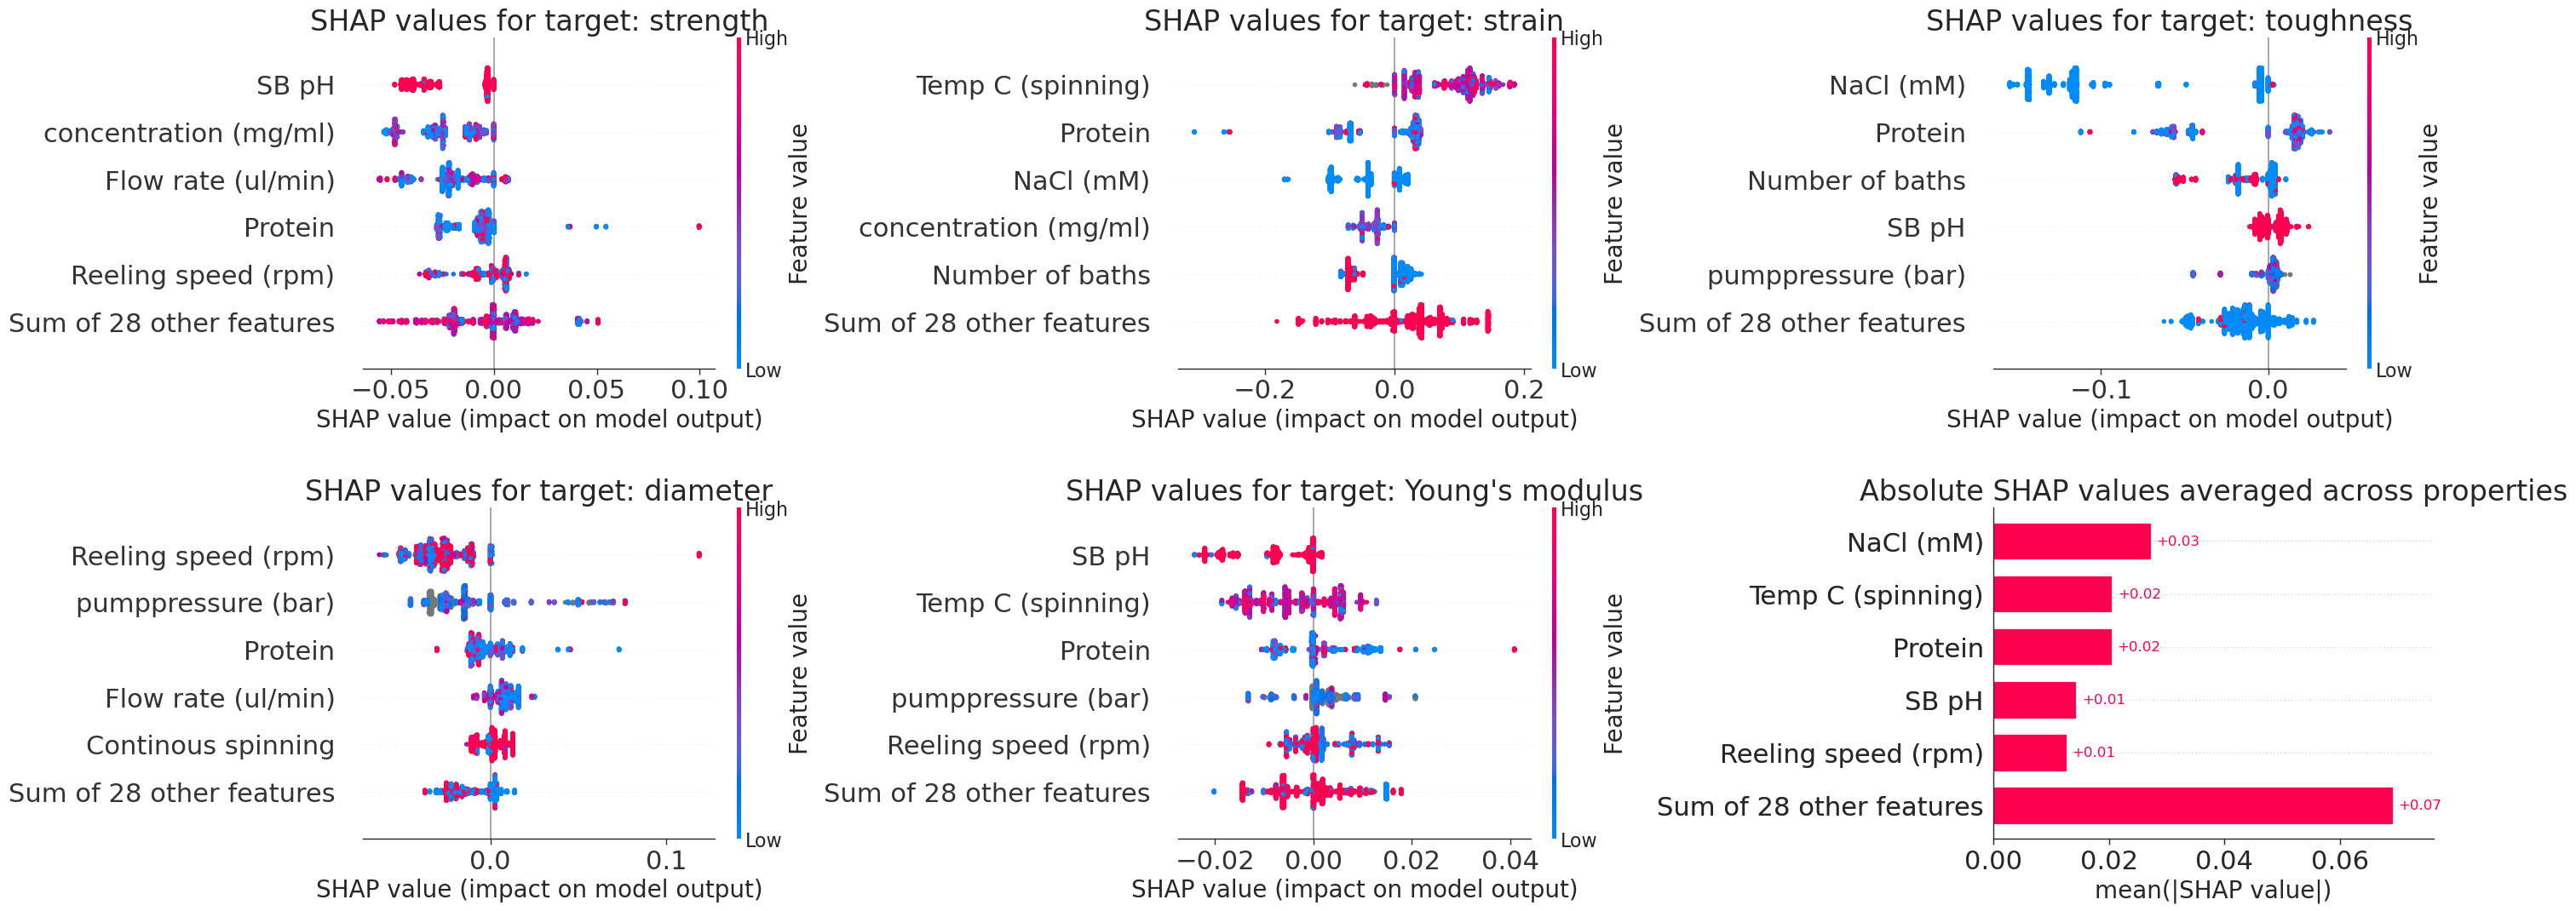

In [25]:
top_features = {}
top_features_avg = {}
for k in 'A', 'B':
    top_features[k] = {}
    combo=True
    format = 'horizontal'
    if format == 'horizontal' and combo:
        fig, ax_ = plt.subplots(2, 3)
        ax = [ax_[0][0], ax_[0][1], ax_[0][2], ax_[1][0], ax_[1][1], ax_[1][2]]
        fig.set_figwidth(25)
        fig.set_figheight(10)
        fig.tight_layout(w_pad=30, h_pad=10)
    else:
        fig = plt.figure(figsize=(17,15))
        ax = [plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2),
            plt.subplot2grid((3,4), (0,2), colspan=2),
            plt.subplot2grid((3,4), (1,0), colspan=2),
            plt.subplot2grid((3,4), (1,2), colspan=2),
            plt.subplot2grid((3,4), (2,0), colspan=2),
            plt.subplot2grid((3,4), (2,2), colspan=2)] if combo \
            else [plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2),
            plt.subplot2grid((3,4), (0,2), colspan=2),
            plt.subplot2grid((3,4), (1,0), colspan=2),
            plt.subplot2grid((3,4), (1,2), colspan=2),
            plt.subplot2grid((3,4), (2,1), colspan=2)]
        fig.tight_layout(w_pad=25, h_pad=7)

    max_display=6

    X_encoded = [pd.DataFrame()] * n_folds
    X_encoded_tot = X_tot[k].copy()
    for fold in range(n_folds):
        X_encoded[fold] = X[k][fold].copy() 
        for col in ds[k].categorical_columns:  
            X_encoded[fold][col] = X_encoded[fold][col].astype("category")
            X_encoded[fold][col] = X_encoded[fold][col].cat.codes  # convert to integer codes
        for col in ds[k].numerical_columns:  
            X_encoded[fold][col] = X_encoded[fold][col].astype("float64")
    for col in ds[k].categorical_columns:  
        X_encoded_tot[col] = X_encoded_tot[col].astype("category")
        X_encoded_tot[col] = X_encoded_tot[col].cat.codes  # convert to integer codes

    target_names = 'strength', 'strain', 'toughness', 'diameter', "Young's modulus"
    features = X_encoded_tot.to_numpy().astype('float64')
    base_values = X_encoded_tot.to_numpy().mean(axis=0)

    shap_values_avg = np.zeros(X_encoded_tot.shape)
    # Loop over each target output
    for i, target in enumerate(targets_ordered):
        shap_values = np.zeros(X_encoded_tot.shape)
        for fold in range(n_folds):
            # Compute SHAP values for the input data
            explainer = shap.Explainer(models[k][targets_ordered[i]][fold])
            shap_values[fold*X_encoded[fold].shape[0] : (fold+1)*X_encoded[fold].shape[0]] = explainer(X_encoded[fold]).values
        shap_values_avg += np.abs(shap_values)
        explanation = shap.Explanation(shap_values, feature_names=X_encoded_tot.columns, data=features, base_values=base_values)
        # Plot summary plot
        color_bar = True#i in [1,3,4]
        shap.plots.beeswarm(explanation, max_display=max_display, ax=ax[i], plot_size=None, show=False, color_bar=color_bar)
        ax[i].set_title(f"SHAP values for target: {target_names[i]}", fontsize=24)
        ax[i].xaxis.set_tick_params(labelsize=22)
        ax[i].yaxis.set_tick_params(labelsize=22)
        ax[i].xaxis.label.set_fontsize(20)
        cbar = fig.axes[-1]
        cbar.tick_params(labelsize=16)
        cbar.set_ylabel('Feature value', fontsize=20)
        top_features_inds = shap_values_avg.mean(axis=0).argsort()[::-1]
        top_features[k][target] = list(X_encoded_tot.columns[top_features_inds])
    shap_values_avg /= 5

    if combo:
        explanation = shap.Explanation(shap_values_avg, feature_names=X_encoded_tot.columns, data=features, base_values=base_values)
        shap.plots.bar(explanation, ax=ax[-1], max_display=max_display, show=False)
        ax[-1].set_title("Absolute SHAP values averaged across properties", fontsize=24)
        ax[-1].xaxis.set_tick_params(labelsize=22)
        ax[-1].yaxis.set_tick_params(labelsize=22)
        ax[-1].xaxis.label.set_fontsize(20)
    plt.show()
    fig.savefig(f'../figures/SHAP_{k}.png', bbox_inches='tight')
    top_features_avg_inds = shap_values_avg.mean(axis=0).argsort()[::-1]
    top_features_avg[k] = list(X_encoded_tot.columns[top_features_avg_inds])

In [26]:
print(top_features_avg)

{'A': ['NaCl (mM)', 'SB pH', 'Temp C (spinning)', 'Protein', 'concentration (mg/ml)', 'Continous spinning', 'Number of baths', 'Reeling speed (rpm)', 'pumppressure (bar)', 'Flow rate (ul/min)', 'Humidity (spinning)', 'Spinning Buffer', 'Capillery size (um)', 'Capillery type', 'Extrusion device', 'Spinning device', 'SB conc. (mM)', 'Temperature SB'], 'B': ['NaCl (mM)', 'Temp C (spinning)', 'Protein', 'SB pH', 'Reeling speed (rpm)', 'concentration (mg/ml)', 'pumppressure (bar)', 'Number of baths', 'Flow rate (ul/min)', 'Continous spinning', 'Humidity (spinning)', 'Capillery size (um)', 'Spinning Buffer', 'Capillery type', 'pca_1', 'pca_8', 'Extrusion device', 'pca_5', 'Spinning device', 'pca_2', 'pca_12', 'pca_6', 'pca_7', 'pca_14', 'pca_4', 'pca_13', 'pca_3', 'pca_9', 'pca_11', 'pca_10', 'SB conc. (mM)', 'pca_15', 'Temperature SB']}


In [27]:
print(top_features)

{'A': {'Strength (MPa)': ['SB pH', 'concentration (mg/ml)', 'Protein', 'Flow rate (ul/min)', 'Reeling speed (rpm)', 'Temp C (spinning)', 'Continous spinning', 'pumppressure (bar)', 'Humidity (spinning)', 'Spinning Buffer', 'NaCl (mM)', 'Number of baths', 'Spinning device', 'Capillery type', 'Extrusion device', 'Capillery size (um)', 'Temperature SB', 'SB conc. (mM)'], 'Strain (mm/mm)': ['Temp C (spinning)', 'SB pH', 'NaCl (mM)', 'concentration (mg/ml)', 'Protein', 'Continous spinning', 'Number of baths', 'Flow rate (ul/min)', 'Reeling speed (rpm)', 'pumppressure (bar)', 'Humidity (spinning)', 'Spinning Buffer', 'Capillery size (um)', 'Capillery type', 'Spinning device', 'Extrusion device', 'Temperature SB', 'SB conc. (mM)'], 'Toughness Modulus (MJ m-3)': ['NaCl (mM)', 'Temp C (spinning)', 'SB pH', 'Protein', 'concentration (mg/ml)', 'Number of baths', 'Continous spinning', 'Flow rate (ul/min)', 'pumppressure (bar)', 'Reeling speed (rpm)', 'Humidity (spinning)', 'Spinning Buffer', 'Capi

In [28]:
a=Y_true_tot.mean().to_numpy().repeat(len(Y_true_tot)).reshape((Y_true_tot.shape[1], Y_true_tot.shape[0])).T
mean_pred = compute_metrics(Y_true_tot, a)
mean_pred

/home/erik/Repositories/Spinning-condition-and-mechanical-properties/src/model_trainer.py:155: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(y_true, y_pred).statistic] # type: ignore


,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,0.108933,0.261298,0.113971,0.072913,0.173300
MAE,0.081433,0.218850,0.083718,0.053848,0.141437
$R^2$,0.000000,0.000000,0.000000,0.000000,0.000000
PCC,NaN,NaN,NaN,NaN,NaN


In [29]:
ds['A'].targets.loc[:,targets_ordered[1]].std()

np.float64(0.2613571953527454)

In [30]:
data_stats

,Strength,Strain,Toughness,Young's modulus,Diameter
Mean,2.58E-01,3.96E-01,2.52E-01,1.91E-01,1.86E-01
SD,1.14E-01,2.61E-01,1.73E-01,1.09E-01,7.29E-02
CV,4.41E-01,6.60E-01,6.89E-01,5.69E-01,3.92E-01


In [31]:
metrics_tot['B']

,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,0.075005,0.214605,0.096852,0.072581,0.156114
MAE,0.050016,0.159792,0.069928,0.053431,0.120396
$R^2$,0.525917,0.325458,0.277846,0.009096,0.188505
PCC,0.729346,0.581050,0.531451,0.226583,0.438982


In [32]:
compute_metrics(Y_true_tot, np.zeros(Y_true_tot.shape))

/home/erik/Repositories/Spinning-condition-and-mechanical-properties/src/model_trainer.py:155: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(y_true, y_pred).statistic] # type: ignore


,Diameter (µm),Strain (mm/mm),Strength (MPa),Youngs Modulus (GPa),Toughness Modulus (MJ m-3)
RMSE,0.220290,0.474290,0.282437,0.199770,0.305599
MAE,0.191472,0.395822,0.258421,0.185988,0.251710
$R^2$,-3.089487,-2.294716,-5.141205,-6.506635,-2.109629
PCC,NaN,NaN,NaN,NaN,NaN


In [33]:
# Top K features selected from SHAP ranking
k = 'B'
K = 10
use_avg = True
ablation_RMSE = pd.DataFrame(columns=targets)
for K_ in tqdm(range(1, K + 1)):
    if use_avg:
        ds_ablation = {target: Dataset(ds[k].df.loc[:, ['Sample number'] + top_features_avg[k][0:K_] + ds[k].target_columns], scaler=scaler) for i, target in enumerate(targets)}
    else:
        ds_ablation = {target: Dataset(ds[k].df.loc[:, ['Sample number'] + top_features[k][target][0:K_] + ds[k].target_columns], scaler=scaler) for i, target in enumerate(targets)}
    params = {target: [model.get_params() for model in models[k][target]] for target in targets}
    models_ablation = {target: mt.train_model(ds_ablation[target], params[target], target=target) for target in targets}

    Y_ablation_pred = [pd.DataFrame(columns=targets) for _ in range(n_folds)]
    for target in targets:
        X_, Y = ds_ablation[target]()
        for fold, (train_idx, test_idx) in enumerate(mt._outer_cv.split(X_, groups=ds['A'].sample_numbers)):
            Y_ablation_pred[fold].loc[:, target] = models_ablation[target][fold].predict(X_.iloc[test_idx].copy())
    for fold in range(3):
        Y_ablation_pred[fold] = Y_ablation_pred[fold].astype(float)
    Y_ablation_pred_tot = pd.DataFrame(data=np.vstack(Y_ablation_pred), columns=Y.columns)
    metrics_ablation_tot = compute_metrics(Y_true_tot, Y_ablation_pred_tot)
    ablation_RMSE.loc[f'$K_{{{K_}}}$'] = metrics_ablation_tot.loc['RMSE']
ablation_RMSE.loc['A'] = metrics_tot['A'].loc['RMSE']
ablation_RMSE.loc['B'] = metrics_tot['B'].loc['RMSE']
ablation_RMSE.loc['M'] = mean_pred.loc['RMSE']

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:51<00:00,  5.12s/it]


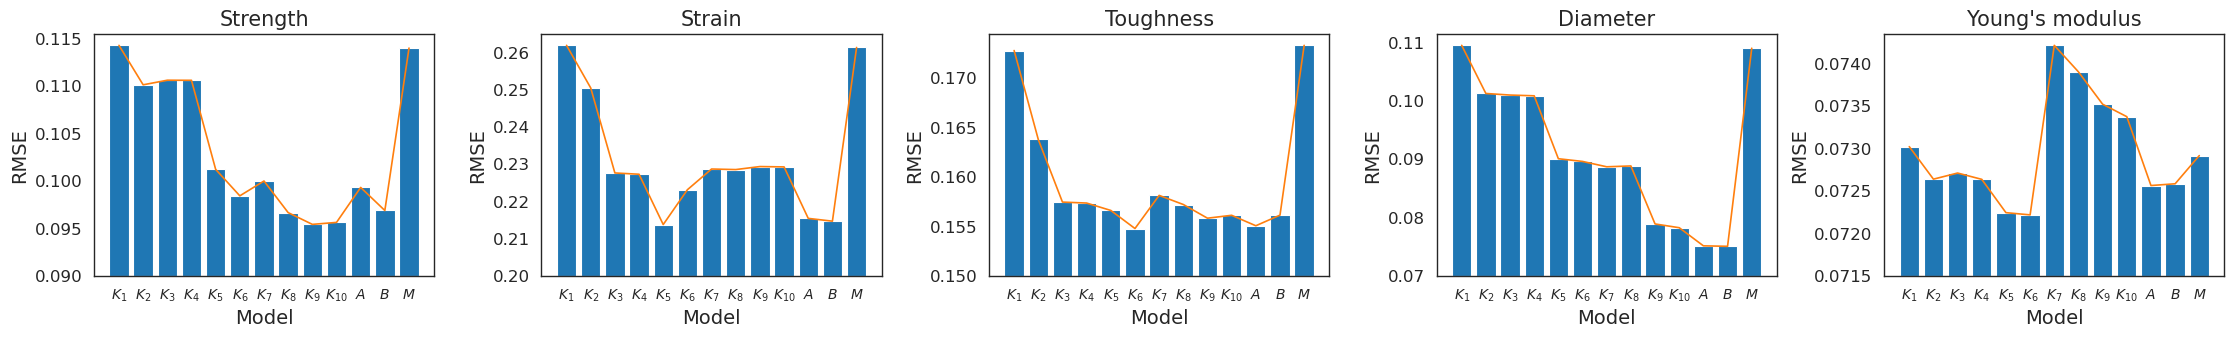

In [34]:
K = 10
inds = list(range(K)) + [-3, -2, -1]
target_names = 'Strength', 'Strain', 'Toughness', 'Diameter', "Young's modulus"
fig, ax = plt.subplots(1, 5)
fig.set_figwidth(22)
fig.set_figheight(3)
fig.tight_layout(w_pad=5)
base = [.09, .2, .15, .07, .0715]
x = [f"$K_{{{k}}}$" for k in range(1, K+1)] + ['$A$', '$B$', '$M$']
for i, target in enumerate(targets_ordered):
    ax[i].set_title(target_names[i], fontsize=15)
    ax[i].bar(#x=ablation_RMSE.index[inds].astype(str), 
              x=x,
              height=ablation_RMSE.loc[:, target].to_numpy()[inds] - base[i],
              bottom=base[i],
              color='tab:blue')
    ax[i].xaxis.set_tick_params(labelsize=10)
    ax[i].yaxis.set_tick_params(labelsize=12)
    ax[i].set_ylabel('RMSE', fontsize=14)
    ax[i].set_xlabel('Model', fontsize=14)

    ax[i].plot(ablation_RMSE.loc[:, target].to_numpy()[inds], color='tab:orange')
    #ax[i].set_xticks(range(len(ablation_RMSE.iloc[inds])))
    #ax[i].set_xticklabels(ablation_RMSE.index[inds].astype(str), fontsize=12)
plt.show()
fig.savefig('../figures/ablation.png', bbox_inches='tight')

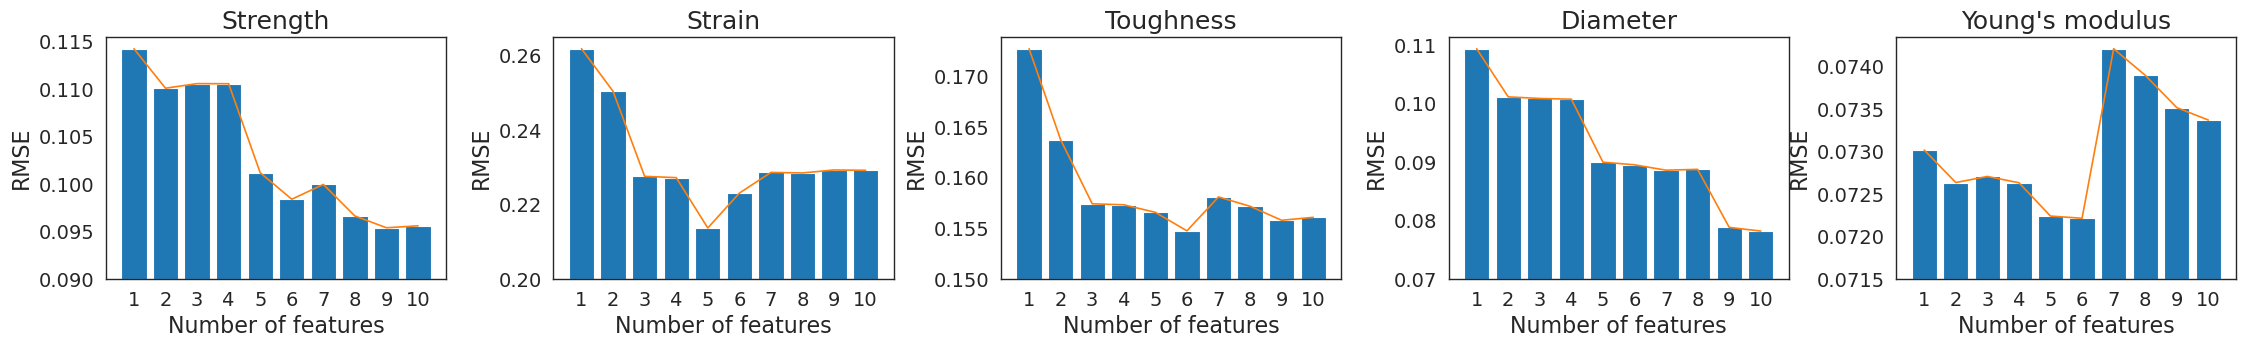

In [38]:
K = 10
inds = list(range(K))
target_names = 'Strength', 'Strain', 'Toughness', 'Diameter', "Young's modulus"
fig, ax = plt.subplots(1, 5)
fig.set_figwidth(22)
fig.set_figheight(3)
fig.tight_layout(w_pad=5)
base = [.09, .2, .15, .07, .0715]
x = [str(i) for i in list(range(1, K+1))]
for i, target in enumerate(targets_ordered):
    y = ablation_RMSE.loc[:, target].to_numpy()[inds]
    ax[i].set_title(target_names[i], fontsize=18)
    ax[i].bar(#x=ablation_RMSE.index[inds].astype(str), 
              x=x,
              height=y - base[i],
              bottom=base[i],
              color='tab:blue')
    ax[i].xaxis.set_tick_params(labelsize=14)
    ax[i].yaxis.set_tick_params(labelsize=14)
    ax[i].set_ylabel('RMSE', fontsize=16)
    ax[i].set_xlabel('Number of features', fontsize=16)

    ax[i].plot(x, y, color='tab:orange')
    ax[i].set_xticks(range(len(ablation_RMSE.iloc[inds])))
plt.show()
fig.savefig('../figures/ablation.png', bbox_inches='tight')

In [73]:
hyper_params = ['learning_rate', 'max_leaf_nodes', 'min_samples_leaf', 'l2_regularization', 'max_iter']
table = pd.DataFrame(index=hyper_params) 
table.loc[:, 'Range'] = ['$[0.01, 0.3]$', '$[10, 50]$', '$[1, 20]$', '$[0.001, 10]$', r'$[0,\infty)^{\mathrm{a}}$']
for k in 'A', 'B':
    df = pd.DataFrame()
    n = 0
    for i in range(5):
        for j in range(3):
            for h in hyper_params:
                df.loc[n, h] = models[k][targets_ordered[i]][j].get_params()[h]
            n += 1
    table.loc[:, f'Values ${k}$'] = df.mean(axis=0).map(lambda x: '{:.2E}'.format(x)) + ' ± ' + df.std(axis=0, ddof=1).map(lambda x: '{:.2E}'.format(x))
table = table.rename(dict(zip(hyper_params, ['Learning rate', 'Max leafs per tree', 'Minimum samples per leaf', '$L_2$ regularization', 'Maximum iterations'])), axis=0)
print(table.to_latex())
table

\begin{tabular}{llll}
\toprule
 & Range & Values $A$ & Values $B$ \\
\midrule
Learning rate & $[0.01, 0.3]$ & 1.02E-01 ± 9.43E-02 & 5.13E-02 ± 3.76E-02 \\
Max leafs per tree & $[10, 50]$ & 1.71E+01 ± 9.54E+00 & 1.86E+01 ± 1.08E+01 \\
Minimum samples per leaf & $[1, 20]$ & 9.73E+00 ± 7.82E+00 & 8.93E+00 ± 6.88E+00 \\
$L_2$ regularization & $[0.001, 10]$ & 2.23E+00 ± 3.10E+00 & 1.79E+00 ± 2.64E+00 \\
Maximum iterations & $[0,\infty)^{\mathrm{a}}$ & 9.11E+01 ± 1.49E+01 & 9.62E+01 ± 1.31E+01 \\
\bottomrule
\end{tabular}



,Range,Values $A$,Values $B$
Learning rate,"$[0.01, 0.3]$",1.02E-01 ± 9.43E-02,5.13E-02 ± 3.76E-02
Max leafs per tree,"$[10, 50]$",1.71E+01 ± 9.54E+00,1.86E+01 ± 1.08E+01
Minimum samples per leaf,"$[1, 20]$",9.73E+00 ± 7.82E+00,8.93E+00 ± 6.88E+00
$L_2$ regularization,"$[0.001, 10]$",2.23E+00 ± 3.10E+00,1.79E+00 ± 2.64E+00
Maximum iterations,"$[0,\infty)^{\mathrm{a}}$",9.11E+01 ± 1.49E+01,9.62E+01 ± 1.31E+01
